In [1]:
%matplotlib inline
import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
%load_ext mcmc
%mcmc notebook

In [2]:
use_dummy_data = True
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

# Sheet Parameters

In [3]:
# important helpers!
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [4]:
stim_current = 1 # current which we are stimulating with
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [5]:
likelihood_variance = 1e-6 # variance for the observation model
run_time = 25 # time at which to run the MCMC

# Load Data

In [6]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

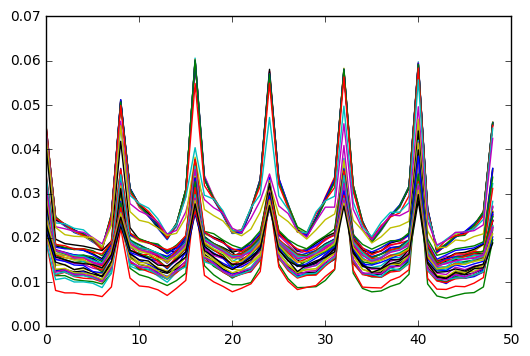

In [7]:
plt.plot(raw_data[:,1:].T);

In [8]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [9]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = other_data.reshape((7,7))
    return res

In [10]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == raw_data[0][1:8])

In [11]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

# Set Up

In [12]:
from bayesian_pdes.problems import eit

In [13]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x - s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [14]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [15]:
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [A, B], [A_bar, B_bar],
    kernel,
    symbols,
    parallel=True
)

In [16]:
#op_system_factory = eit.EITFactory(kernel, symbols[0], symbols[1], symbols[2])

## Define the collocation grid

In [17]:
r = 1.0 # todo: just assume a unit radius, is this okay?
n_in_shell = 10

In [18]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords


In [19]:
shell_radii = np.linspace(0, r, n_in_shell)[1:-1]
design_int = construct_shell(shell_radii)

In [20]:
n_bdy = 64
bdy_theta = np.linspace(0, 2*np.pi, n_bdy+1)
design_bdy = pol2cart(np.c_[np.ones(n_bdy), bdy_theta[:-1]]) 

# define the mapping from boundary collocation point to sensor
bdy_sensor_skip = 8
sensor_ixs = np.arange(0, len(design_bdy), bdy_sensor_skip)
is_sensor_flags = np.in1d(np.arange(len(design_bdy)), sensor_ixs)

sensor_xy = design_bdy[is_sensor_flags]
non_sensor_xy = design_bdy[~is_sensor_flags]
print('{} sensors'.format(len(sensor_xy)))
print('{} non-sensors'.format(len(non_sensor_xy)))

8 sensors
56 non-sensors


In [21]:
# for now we impose the BC only at the sensor locations and impose the interior condition at non-sensor bdy points
#modified_design_int = np.row_stack([design_int, non_sensor_xy])
modified_design_bdy = sensor_xy

In [22]:
full_design = np.row_stack([modified_design_int, modified_design_bdy])
len(full_design)

291

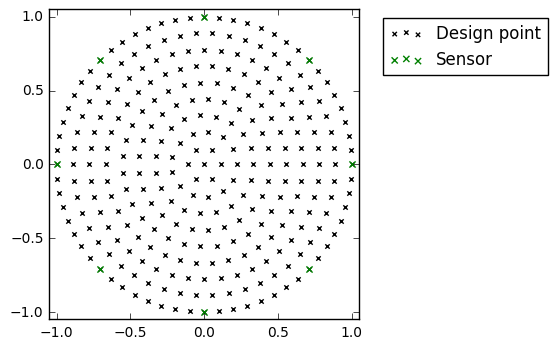

In [23]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(design_int[:,0], design_int[:,1], marker='x', color='black', s=10)
plt.scatter(design_bdy[:,0], design_bdy[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(sensor_xy[:,0], sensor_xy[:,1], marker='x', color='green', label='Sensor')
plt.xlim(-r*1.05,r*1.05);plt.ylim(-r*1.05,r*1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

In [24]:
# TO DO:
# * Check this in
# * Swap to simulating only the field
# * Swap to simulating only a lower dimensional version of the field
def theta_to_a(theta, sz_int, sz_bdy):
    kappa_int = theta[:sz_int]
    kappa_bdy = theta[sz_int:sz_int+sz_bdy]
    grad_kappa_x = theta[sz_int+sz_bdy:2*sz_int+sz_bdy]
    grad_kappa_y = theta[2*sz_int+sz_bdy:]
    return kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y

## Define the Potential

In [65]:
# todo: choose this in a more principled way
length_scale = 0.2
kernel_variance = 0.01**2
fun_args = np.array([length_scale, kernel_variance])

In [66]:
def construct_posterior(theta, debug=False):
    a_int, a_bdy, a_x, a_y = theta_to_a(theta,
                                        modified_design_int.shape[0], 
                                        modified_design_bdy.shape[0]
                                       )
    
    augmented_int = np.column_stack([modified_design_int, a_int, a_x, a_y])
    augmented_bdy = np.column_stack([modified_design_bdy, a_bdy, np.nan*np.zeros((a_bdy.shape[0], 2))])
    obs = [
        (augmented_int, None),
        (augmented_bdy, None)
    ]
    posterior = bpdes.collocate(
        op_system.operators,
        op_system.operators_bar,
        obs,
        op_system,
        fun_args,
        inverter='np'
    )
    return posterior

In [67]:
def phi(theta, debug=False):
    # first solve forward
    posterior = construct_posterior(theta, debug=debug)
    # now determine voltage at the sensor locations
    # we have seven observations so take one for each sensor other than sensor 1, the reference sensor
    augmented_locations = np.column_stack([sensor_xy[1:], np.nan*np.zeros((7,3))])
    mu_mult, Sigma = posterior.no_obs_posterior(augmented_locations)
    
    # now need to iterate the stim patterns and compute the residual
    data = data_dict[run_time] if not use_dummy_data else dummy_data
    rhs_int = np.zeros((len(modified_design_int), 1))
        
    likelihood_cov = Sigma + likelihood_variance*np.eye(Sigma.shape[0])
    #likelihood_cov = likelihood_variance*np.eye(Sigma.shape[0])
    likelihood_dist = stats.multivariate_normal(np.zeros(Sigma.shape[0]), likelihood_cov)
    
    if debug:
        print("Sigma diag: {}\tCondition:{} \t Augmented Condition: {}".format(np.diag(Sigma), np.linalg.cond(Sigma), np.linalg.cond(likelihood_cov)))
    
    likelihood = 0
    for voltage, current in zip(data, stim_pattern):
        rhs_bdy = current[:,None]
        rhs = np.row_stack([rhs_int, rhs_bdy])
        
        model_voltage = np.dot(mu_mult, rhs)
        
        this_likelihood = likelihood_dist.logpdf(voltage.ravel() - model_voltage.ravel())
        if debug:
            print("Model|True\n {}".format(np.c_[model_voltage, voltage]))
            print("Likelihood: {}".format(this_likelihood))
        likelihood += this_likelihood
    return -likelihood

In [68]:
data_dict[run_time]

array([[ 0.03362  ,  0.01703  ,  0.01669  ,  0.0161   ,  0.01611  ,
         0.0152   ,  0.0141625],
       [ 0.01742  ,  0.03424  ,  0.01959  ,  0.01735  ,  0.01732  ,
         0.01648  ,  0.0157225],
       [ 0.01634  ,  0.01843  ,  0.03622  ,  0.01947  ,  0.01798  ,
         0.01715  ,  0.0159125],
       [ 0.015    ,  0.01597  ,  0.01879  ,  0.03004  ,  0.01856  ,
         0.01643  ,  0.0152825],
       [ 0.01459  ,  0.01594  ,  0.01688  ,  0.01851  ,  0.03062  ,
         0.01831  ,  0.0155825],
       [ 0.01392  ,  0.01499  ,  0.01606  ,  0.01667  ,  0.0178   ,
         0.03597  ,  0.0160925],
       [ 0.01275  ,  0.01295  ,  0.01441  ,  0.01469  ,  0.01487  ,
         0.01501  ,  0.02824  ]])

## Set up Proposal Matrix

In [69]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [95]:
proposal_length_scale = 0.1
proposal_variance = 0.01
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y],
    [(), diff_x_bar, diff_y_bar],
    [full_design, modified_design_int, modified_design_int],
    [full_design, modified_design_int, modified_design_int],
    proposal_op_system,
    np.array([proposal_length_scale, proposal_variance])
)
np.linalg.cond(proposal_cov)

27010913.639298182

In [77]:
mcmc.pcn.sqrtm_mode = mcmc.pcn.SQRTM_SCIPY
proposal = mcmc.pcn.proposal(0.05, proposal_cov)
kappa_0 = np.random.multivariate_normal(np.zeros(proposal_cov.shape[0]), proposal_cov)
#kappa_0 = proposals[-1,:]
kappa_0 = dummy_true_field

In [78]:
%time phi(kappa_0, False)

CPU times: user 91.9 ms, sys: 5.85 ms, total: 97.8 ms
Wall time: 43.3 ms


-281.15802562792936

In [79]:
proposals, acceptances = mcmc.pCN(10000, proposal, phi, kappa_0)

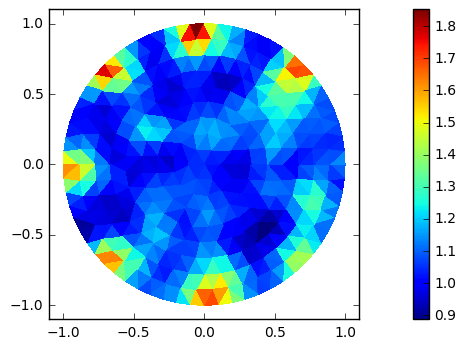

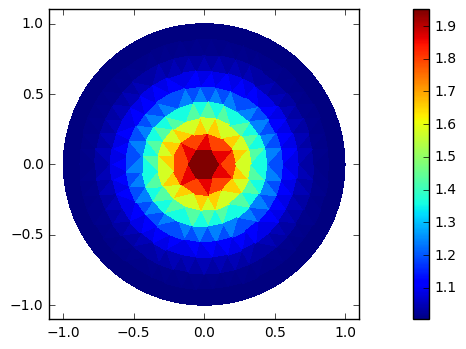

In [80]:
thin = 1
burn = int(proposals.shape[0]) / 2

recovered_field = proposals[burn::thin, :len(full_design)].mean(axis=0)
#recovered_field = proposals[-1, :len(full_design)]
plot_circle(full_design[:,0], full_design[:,1], np.exp(recovered_field))
plt.savefig('results/t={}_field.pdf'.format(run_time))
plt.figure()
plot_circle(full_design[:,0], full_design[:,1], np.exp(kappa_0[:len(full_design)]))

In [82]:
phi(dummy_true_field)

-281.15802562792936

In [83]:
phi(proposals[-1,:])

-244.84663631247821

In [88]:
p = construct_posterior(proposals[-1,:])
mu_mult, cov = p.no_obs_posterior(np.column_stack([sensor_xy[1:], np.empty((7,3))]))

In [92]:
mu_mult.dot(np.row_stack([
            np.zeros((len(modified_design_int), 1)),
            stim_pattern[0][:,None]
            ]
                         ))

array([[-0.07996229],
       [-0.00352617],
       [-0.00195872],
       [ 0.0001198 ],
       [-0.00139098],
       [-0.00278277],
       [-0.0005504 ]])

In [43]:
np.save('results/t={}_samples.npy'.format(run_time), recovered_field)

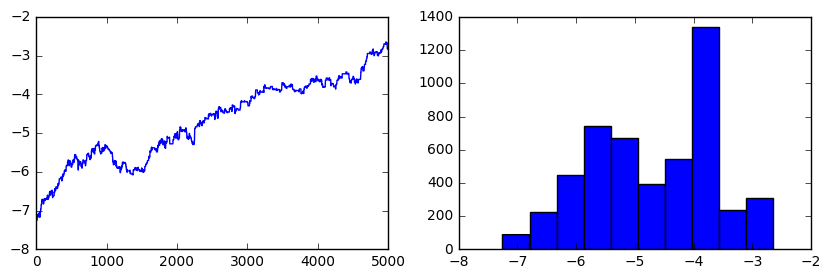

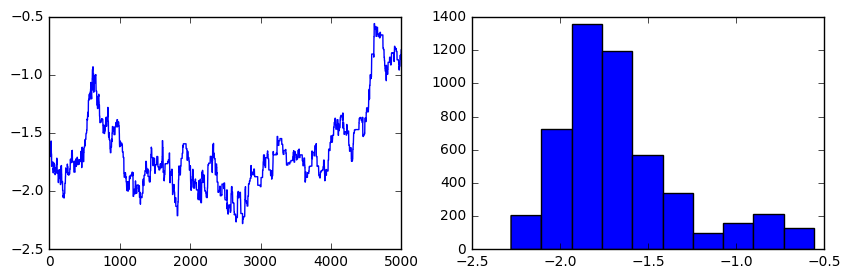

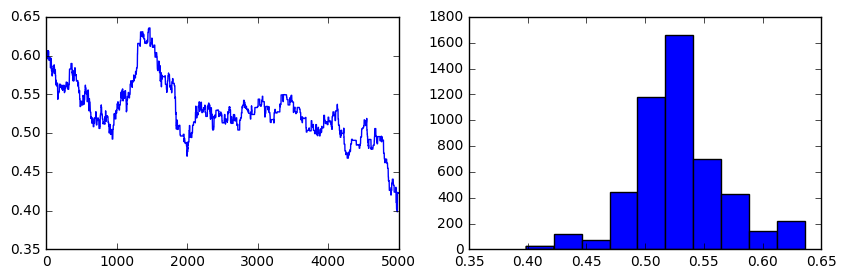

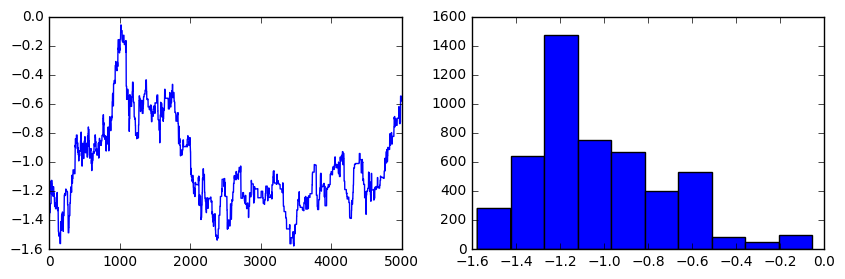

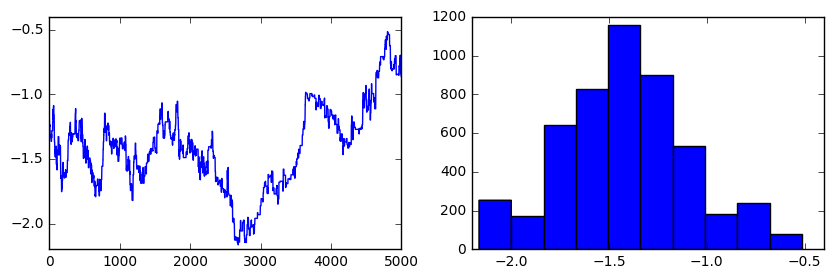

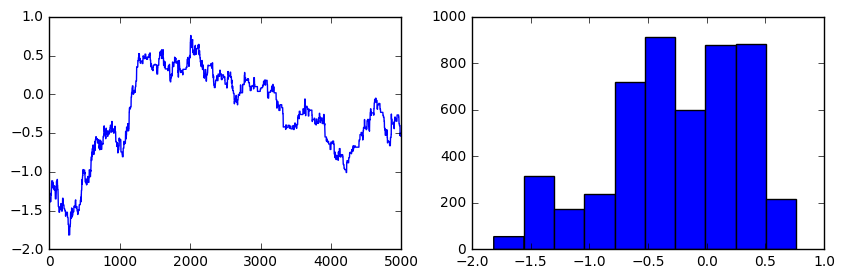

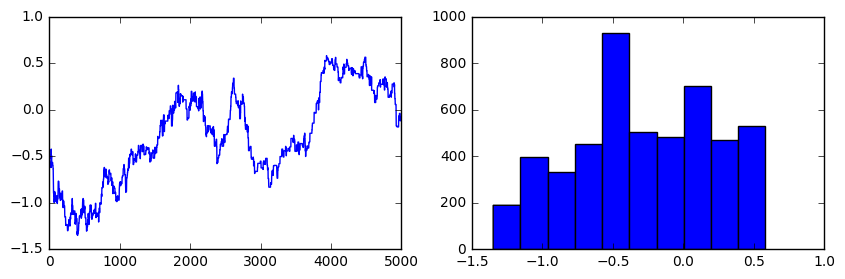

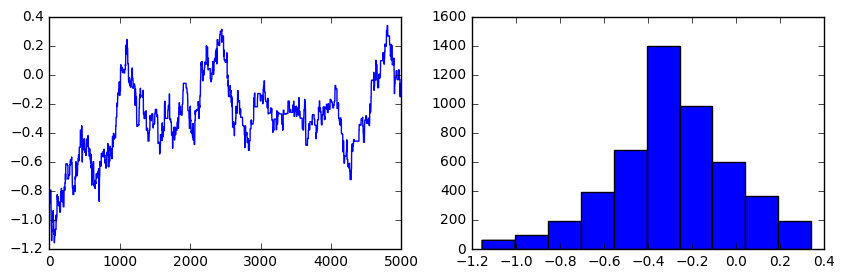

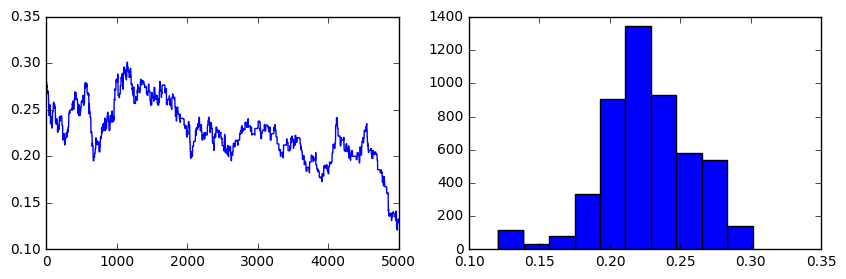

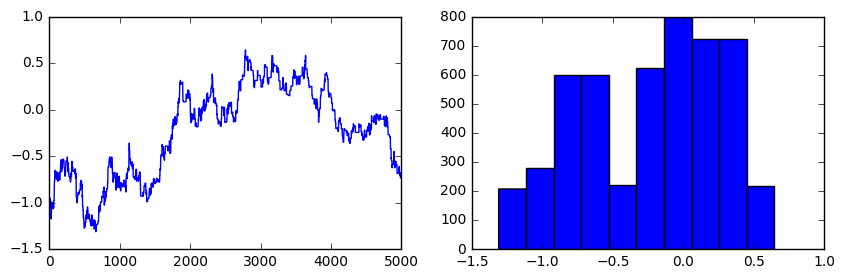

In [84]:
for i in np.random.choice(proposals.shape[1], 10):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(proposals[burn::thin,i])
    plt.subplot(122)
    plt.hist(proposals[burn::thin,i])

In [45]:
phi(proposals[-1,:], True)

Sigma diag: [ 0.00049328  0.00057323  0.00055129  0.00051344  0.0005389   0.00052811
  0.00051079]	Condition:69.2286339136 	 Augmented Condition: 67.6428685999
Model|True
 [[ -1.17704490e-01  -7.57607263e-02]
 [ -1.87989336e-02  -1.96629828e-03]
 [ -1.84398997e-02  -2.94578944e-04]
 [ -8.10201990e-03  -1.95269582e-04]
 [ -1.30145992e-02  -1.30296667e-04]
 [ -2.22713309e-02   2.76267061e-05]
 [ -1.46925023e-02   1.79044662e-03]]
Likelihood: 19.3249561032
Model|True
 [[-0.0055879  -0.00010788]
 [-0.09619472 -0.07804287]
 [-0.00179751 -0.00262509]
 [-0.0101895  -0.0005507 ]
 [-0.00732951 -0.00031265]
 [-0.01115874 -0.00011558]
 [-0.004035    0.00192976]]
Likelihood: 22.4673150644
Model|True
 [[-0.00528443  0.00157949]
 [-0.0017004  -0.00258887]
 [-0.09828949 -0.07848592]
 [ 0.00304079 -0.00262375]
 [-0.00922136 -0.00055012]
 [-0.02175568 -0.00026004]
 [-0.01376028  0.00179266]]
Likelihood: 20.2710077615
Model|True
 [[-0.01325105  0.0016623 ]
 [-0.01355292 -0.00055894]
 [ 0.00462826 -0.002

-141.40731330153778

In [64]:
phi(kappa_0, True)

Sigma diag: [ 0.00040857  0.00040846  0.00040829  0.00040834  0.00040829  0.00040846
  0.00040857]	Condition:2674.23406475 	 Augmented Condition: 1379.17420544
Model|True
 [[ -7.57607263e-02  -7.57607263e-02]
 [ -1.96629828e-03  -1.96629828e-03]
 [ -2.94578944e-04  -2.94578944e-04]
 [ -1.95269582e-04  -1.95269582e-04]
 [ -1.30296667e-04  -1.30296667e-04]
 [  2.76267061e-05   2.76267061e-05]
 [  1.79044662e-03   1.79044662e-03]]
Likelihood: 34.5901169921
Model|True
 [[-0.00010788 -0.00010788]
 [-0.07804287 -0.07804287]
 [-0.00262509 -0.00262509]
 [-0.0005507  -0.0005507 ]
 [-0.00031265 -0.00031265]
 [-0.00011558 -0.00011558]
 [ 0.00192976  0.00192976]]
Likelihood: 34.5901169921
Model|True
 [[ 0.00157949  0.00157949]
 [-0.00258887 -0.00258887]
 [-0.07848592 -0.07848592]
 [-0.00262375 -0.00262375]
 [-0.00055012 -0.00055012]
 [-0.00026004 -0.00026004]
 [ 0.00179266  0.00179266]]
Likelihood: 34.5901169921
Model|True
 [[ 0.0016623   0.0016623 ]
 [-0.00055894 -0.00055894]
 [-0.00263474 -0.002

-242.13081894490892